In [1]:
import findspark
findspark.init()

In [7]:
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession


# start a spark session 
#spark = SparkSession.builder.master("local").appName(" Churn Models").config(
#    "spark.executor.memory", "8g").config(
#    "spark.driver.memory", "15g").getOrCreate()
spark = SparkSession.builder.master("local").appName("Churn Models").config(
    "spark.driver.maxResultSize", "15g").config("spark.driver.memory", "15g").getOrCreate()

# load data with inferred schema 
df = spark.read.load("C:/Users/mugdh/Downloads/Train.csv", 
                     format="csv", inferSchema="true", header="true")

# The inferred schema can be seen using .printSchema().
df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- REGION: string (nullable = true)
 |-- TENURE: string (nullable = true)
 |-- MONTANT: double (nullable = true)
 |-- FREQUENCE_RECH: double (nullable = true)
 |-- REVENUE: double (nullable = true)
 |-- ARPU_SEGMENT: double (nullable = true)
 |-- FREQUENCE: double (nullable = true)
 |-- DATA_VOLUME: double (nullable = true)
 |-- ON_NET: double (nullable = true)
 |-- ORANGE: double (nullable = true)
 |-- TIGO: double (nullable = true)
 |-- ZONE1: double (nullable = true)
 |-- ZONE2: double (nullable = true)
 |-- MRG: string (nullable = true)
 |-- REGULARITY: integer (nullable = true)
 |-- TOP_PACK: string (nullable = true)
 |-- FREQ_TOP_PACK: double (nullable = true)
 |-- CHURN: integer (nullable = true)



In [3]:
print((df.count(), len(df.columns)))


(2154048, 19)


There are 21,54,048 observations and 19 attributes---14 are numeric, while 5 are categorical columns

In [4]:
df.show(5)

+--------------------+------+-------------+-------+--------------+-------+------------+---------+-----------+------+------+----+-----+-----+---+----------+--------------------+-------------+-----+
|             user_id|REGION|       TENURE|MONTANT|FREQUENCE_RECH|REVENUE|ARPU_SEGMENT|FREQUENCE|DATA_VOLUME|ON_NET|ORANGE|TIGO|ZONE1|ZONE2|MRG|REGULARITY|            TOP_PACK|FREQ_TOP_PACK|CHURN|
+--------------------+------+-------------+-------+--------------+-------+------------+---------+-----------+------+------+----+-----+-----+---+----------+--------------------+-------------+-----+
|00000bfd7d50f0109...|FATICK| K > 24 month| 4250.0|          15.0| 4251.0|      1417.0|     17.0|        4.0| 388.0|  46.0| 1.0|  1.0|  2.0| NO|        54|On net 200F=Unlim...|          8.0|    0|
|00000cb4a5d760de8...|  null|I 18-21 month|   null|          null|   null|        null|     null|       null|  null|  null|null| null| null| NO|         4|                null|         null|    1|
|00001654a9d9f9

In [4]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
user_id,2154048,None,None,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,fffff6dbff1508ea2bfe814e5ab2729ce6b788c2
REGION,1304749,None,None,DAKAR,ZIGUINCHOR
TENURE,2154048,None,None,D 3-6 month,K > 24 month
MONTANT,1397309,5532.11699774352,7111.339420558589,10.0,470000.0
FREQUENCE_RECH,1397309,11.529119901181485,13.274069546587256,1.0,133.0
REVENUE,1428000,5510.810334033614,7187.112880298437,1.0,532177.0
ARPU_SEGMENT,1428000,1836.942893557423,2395.6999535125306,0.0,177392.0
FREQUENCE,1428000,13.978141456582634,14.69403468069742,1.0,91.0
DATA_VOLUME,1093615,3366.4501666491406,13304.46366732358,0.0,1823866.0


In [60]:
#Missing Values
from pyspark.sql.functions import when, count, col
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().T


,0
user_id,0
REGION,849299
TENURE,0
MONTANT,756739
FREQUENCE_RECH,756739
REVENUE,726048
ARPU_SEGMENT,726048
FREQUENCE,726048
DATA_VOLUME,1060433
ON_NET,786675


In [5]:
from pyspark.sql.functions import *
amount_missing_df = df.select([(count(when(isnan(c) | col(c).isNull(), c))/count(lit(1))).alias(c) for c in df.columns]).toPandas().T
amount_missing_df


,0
user_id,0.000000
REGION,0.394280
TENURE,0.000000
MONTANT,0.351310
FREQUENCE_RECH,0.351310
REVENUE,0.337062
ARPU_SEGMENT,0.337062
FREQUENCE,0.337062
DATA_VOLUME,0.492298
ON_NET,0.365208


There are considerable missing values in 14 out of 19 columns.

In [79]:
# select columns 
df.select("churn").show(3)

+-----+
|churn|
+-----+
|    0|
|    1|
|    0|
+-----+
only showing top 3 rows



In [6]:
# count the occurance of each unique value 
display(df.groupBy("churn").count().show())

+-----+-------+
|churn|  count|
+-----+-------+
|    1| 403986|
|    0|1750062|
+-----+-------+



None

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
#Running Query
from pyspark.sql import SQLContext

df_pd = df.toPandas()

In [8]:
len(df_pd.query('MONTANT > REVENUE'))

497807

In [4]:
df_pd.head(10)

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,FATICK,K > 24 month,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,NO,54,On net 200F=Unlimited _call24H,8.0,0
1,00000cb4a5d760de88fecb38e2f71b7bec52e834,None,I 18-21 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,4,None,NaN,1
2,00001654a9d9f96303d9969d0a4a851714a4bb57,None,K > 24 month,3600.0,2.0,1020.0,340.0,2.0,NaN,90.0,46.0,7.0,NaN,NaN,NO,17,On-net 1000F=10MilF;10d,1.0,0
3,00001dd6fa45f7ba044bd5d84937be464ce78ac2,DAKAR,K > 24 month,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,NaN,NaN,NO,62,"Data:1000F=5GB,7d",11.0,0
4,000028d9e13a595abe061f9b58f3d76ab907850f,DAKAR,K > 24 month,1000.0,1.0,985.0,328.0,1.0,NaN,39.0,24.0,NaN,NaN,NaN,NO,11,Mixt 250F=Unlimited_call24H,2.0,0
5,0000296564272665ccd2925d377e124f3306b01e,LOUGA,K > 24 month,8500.0,17.0,9000.0,3000.0,18.0,NaN,252.0,70.0,91.0,NaN,NaN,NO,62,MIXT:500F= 2500F on net _2500F off net;2d,18.0,0
6,00002b0ed56e2c199ec8c3021327229afa70f063,LOUGA,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,2,None,NaN,0
7,0000313946b6849745963442c6e572d47cd24ced,DAKAR,K > 24 month,7000.0,16.0,7229.0,2410.0,22.0,1601.0,77.0,29.0,100.0,NaN,NaN,NO,55,All-net 500F=2000F;5d,8.0,0
8,0000398021ccd3a488fa1a63dee3b2f0d471f9fd,DAKAR,K > 24 month,1500.0,3.0,1502.0,501.0,12.0,NaN,2.0,53.0,2.0,NaN,NaN,NO,31,None,NaN,0
9,00003d165737109921ebd21f883cb8cff028b626,TAMBACOUNDA,K > 24 month,4000.0,8.0,4000.0,1333.0,8.0,NaN,1620.0,9.0,NaN,NaN,NaN,NO,45,On-net 500F_FNF;3d,8.0,0


In [7]:
df_pd.nunique()

user_id           2154048
REGION                 14
TENURE                  8
MONTANT              6540
FREQUENCE_RECH        123
REVENUE             38114
ARPU_SEGMENT        16535
FREQUENCE              91
DATA_VOLUME         41550
ON_NET               9884
ORANGE               3167
TIGO                 1315
ZONE1                 612
ZONE2                 486
MRG                     1
REGULARITY             62
TOP_PACK              140
FREQ_TOP_PACK         245
CHURN                   2
dtype: int64

<ipython-input-72-f1889be56ce5>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df_pd.hist(ax=ax);


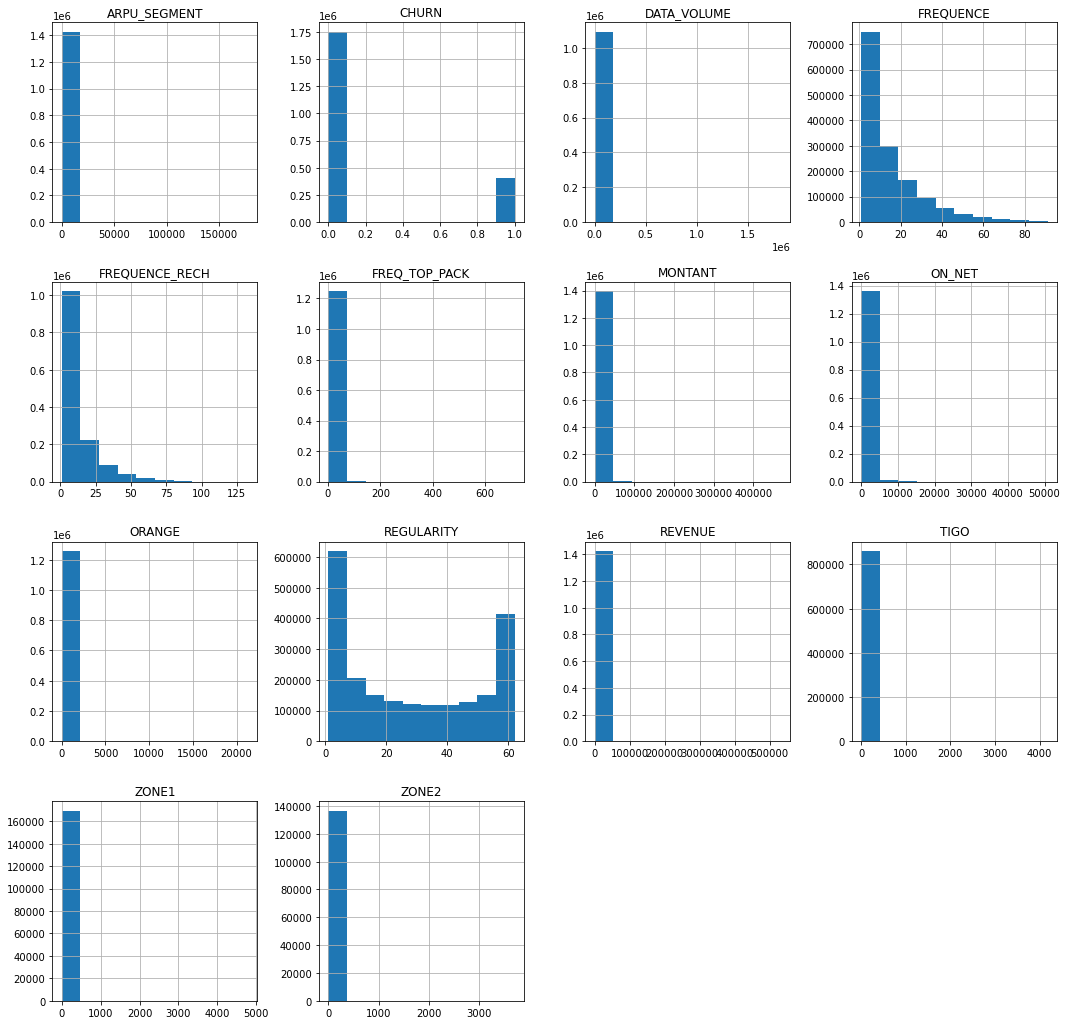

In [72]:

gig, ax = plt.subplots(figsize=(18, 18))
df_pd.hist(ax=ax);

In [9]:
df_pd['CHURN'].value_counts(normalize=True)

0    0.812453
1    0.187547
Name: CHURN, dtype: float64

The target variable has imbalanced classes - 18.7% of the customers churned, which implies that Expresso had more of loyal customers than those who churned.



Text(0.5, 1.0, 'Distribution of customers by churn')

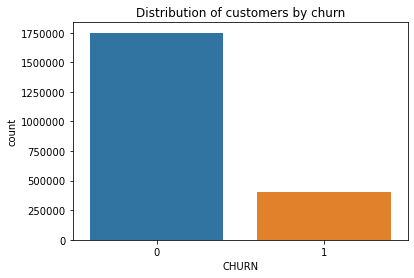

In [23]:

ax = sns.countplot(x="CHURN", data=df_pd)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.title('Distribution of customers by churn')

In [8]:
df_pd['REGION'].value_counts(normalize=True)

DAKAR          0.393387
THIES          0.137997
SAINT-LOUIS    0.091884
LOUGA          0.075917
KAOLACK        0.074333
DIOURBEL       0.051283
TAMBACOUNDA    0.042210
KAFFRINE       0.033695
KOLDA          0.029694
FATICK         0.027318
MATAM          0.022290
ZIGUINCHOR     0.016819
SEDHIOU        0.002390
KEDOUGOU       0.000782
Name: REGION, dtype: float64

In [7]:
df_pd['TENURE'].value_counts(normalize=True)

K > 24 month     0.948540
I 18-21 month    0.021020
H 15-18 month    0.012073
G 12-15 month    0.006918
J 21-24 month    0.005907
F 9-12 month     0.004330
E 6-9 month      0.000854
D 3-6 month      0.000357
Name: TENURE, dtype: float64

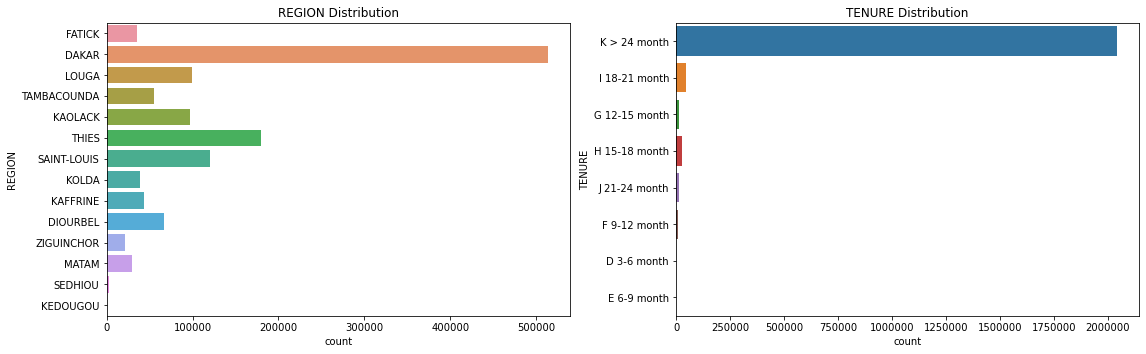

In [6]:
plt.figure(figsize=(16,5))
for i,col in enumerate(['REGION', 'TENURE'], start=1):
    plt.subplot(1,2, i)
    sns.countplot(y=df_pd[col])
    plt.title(col + ' Distribution')
    plt.xticks()
plt.tight_layout(pad=1.)
plt.ticklabel_format(style='plain', axis='x',useOffset=False);

This data was collected from the Senegal market. Dakar is the most popular city where the customers are from.
Most of the customers have been with the company for more than 2 years


In [10]:
df_pd.query('CHURN == 1')['REGION'].value_counts(normalize=True)[:10].sort_values(ascending=False)

DAKAR          0.419931
THIES          0.124835
KAOLACK        0.096678
DIOURBEL       0.079963
LOUGA          0.067203
SAINT-LOUIS    0.064651
TAMBACOUNDA    0.035983
ZIGUINCHOR     0.025605
MATAM          0.024839
FATICK         0.021522
Name: REGION, dtype: float64

In [41]:
df_pd['TOP_PACK'].value_counts()[:10].sort_values(ascending=False)

All-net 500F=2000F;5d                        317802
On net 200F=Unlimited _call24H               152295
Data:490F=1GB,7d                             115180
Data: 100 F=40MB,24H                          84649
Mixt 250F=Unlimited_call24H                   67512
MIXT:500F= 2500F on net _2500F off net;2d     64412
Data:1000F=2GB,30d                            59770
All-net 500F =2000F_AllNet_Unlimited          46890
Jokko_Daily                                   45036
Data: 200 F=100MB,24H                         42841
Name: TOP_PACK, dtype: int64

In [156]:
df_pd['TOP_PACK']= df_pd['TOP_PACK'].fillna('Others')

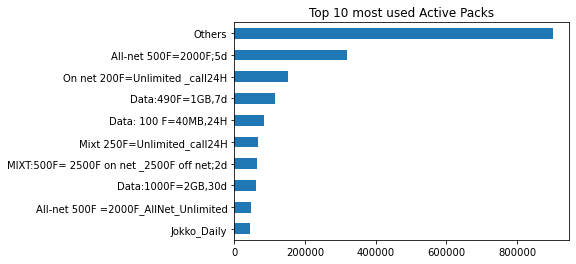

In [157]:
df_pd.TOP_PACK.value_counts()[:10].sort_values().plot.barh(title='Top 10 most used Active Packs');

In [158]:
df_pd.query('CHURN == 1')['TOP_PACK'].value_counts(normalize=True)[:10].sort_values(ascending=False)

Others                            0.875590
All-net 500F=2000F;5d             0.025446
Data:490F=1GB,7d                  0.018018
Data: 100 F=40MB,24H              0.009696
Data:1000F=2GB,30d                0.007515
On net 200F=Unlimited _call24H    0.007154
Mixt 250F=Unlimited_call24H       0.007042
Data: 200 F=100MB,24H             0.006525
Jokko_Daily                       0.005042
Data:1000F=5GB,7d                 0.003683
Name: TOP_PACK, dtype: float64

<Figure size 1152x864 with 0 Axes>

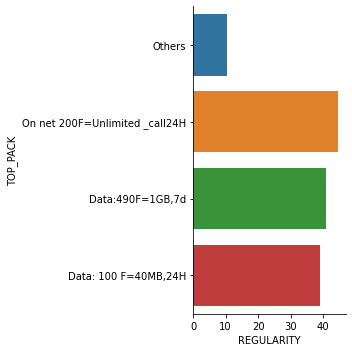

In [178]:
plt.figure(figsize=(16,12))

plot_order = df_pd.groupby('TOP_PACK')['REGULARITY'].sum().sort_values(ascending=False).index.values

sns.catplot(data=df_pd, x='REGULARITY',  y='TOP_PACK',kind='bar',ci=None,legend_out=False, order=plot_order[1:5])

customers under 'Others', that is those who were not using the top active packs were active for about 10 times in 90 days

In [59]:
df_pd['FREQ_TOP_PACK'].value_counts()[:10].sort_values(ascending=False)

1.0     251882
2.0     155396
3.0     116447
4.0      85552
5.0      68531
6.0      57092
7.0      49478
8.0      43188
9.0      38731
10.0     34641
Name: FREQ_TOP_PACK, dtype: int64

In [154]:
df_pd.query('CHURN == 1')['FREQ_TOP_PACK'].value_counts(normalize=True)[:10].sort_values(ascending=False)

1.0     0.425686
2.0     0.173060
3.0     0.095384
4.0     0.062435
5.0     0.044489
6.0     0.033307
7.0     0.025766
8.0     0.020454
9.0     0.016216
10.0    0.014127
Name: FREQ_TOP_PACK, dtype: float64

In [155]:
df_pd.query('CHURN == 0')['FREQ_TOP_PACK'].value_counts(normalize=True)[:10].sort_values(ascending=False)

1.0     0.191882
2.0     0.122127
3.0     0.092952
4.0     0.068610
5.0     0.055191
6.0     0.046136
7.0     0.040113
8.0     0.035098
9.0     0.031565
10.0    0.028248
Name: FREQ_TOP_PACK, dtype: float64

In [82]:
df_pd['REGULARITY'].mean()

28.0425050880946

In [12]:
df_pd.groupby('CHURN')['REGULARITY'].mean()

CHURN
0    33.182215
1     5.777349
Name: REGULARITY, dtype: float64

Text(0.5, 1.0, 'Distribution of churn by regularity')

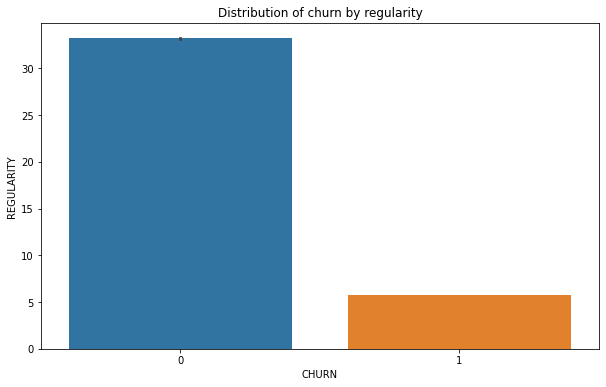

In [39]:
plt.figure(figsize=(10,6))
sns.barplot(x= 'CHURN', y= 'REGULARITY', data= df_pd)
plt.title('Distribution of churn by regularity')

Customers who churned were not active for more than 6 times in the course of 90 days

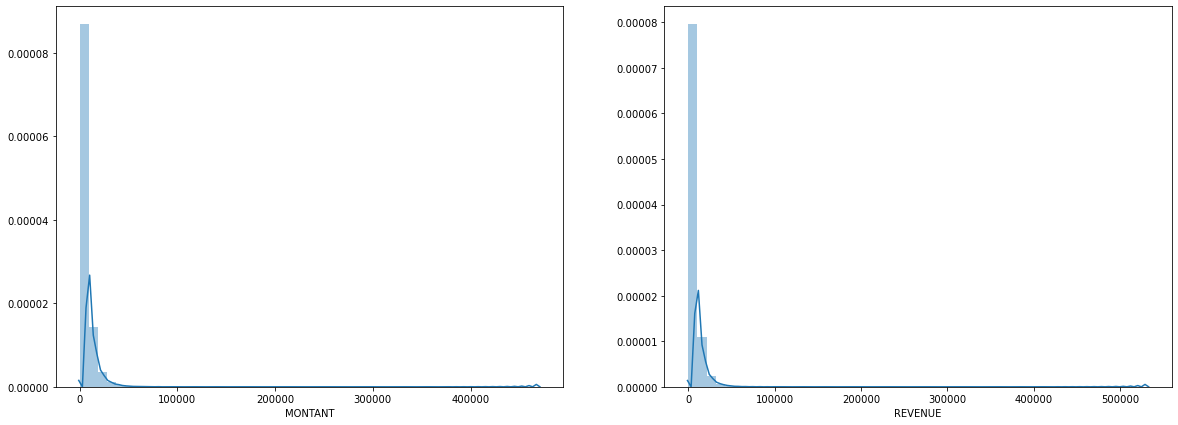

In [131]:
# set a larger figure size for subplots
plt.figure(figsize = [20, 7]) 

# histogram on left, example of too-large bin size
# 1 row, 2 cols, subplot 1
plt.subplot(1, 2, 1) 
sns.distplot(df_pd['MONTANT'])
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
# histogram on right, example of too-small bin size
plt.subplot(1, 2, 2) # 1 row, 2 cols, subplot 2
sns.distplot(df_pd['REVENUE'])
plt.ticklabel_format(style='plain', axis='y',useOffset=False);

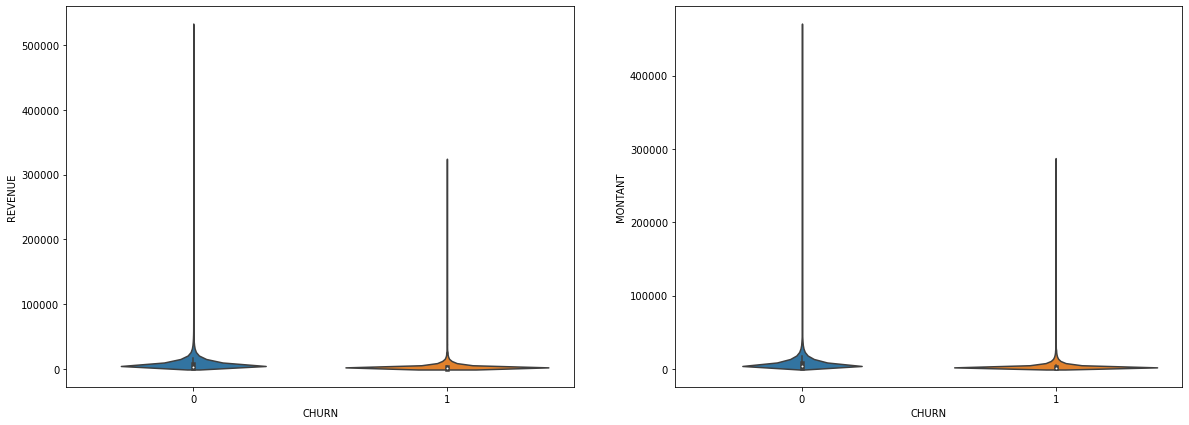

In [136]:
# set a larger figure size for subplots
plt.figure(figsize = [20, 7]) 

# histogram on left, example of too-large bin size
# 1 row, 2 cols, subplot 1
plt.subplot(1, 2, 1) 
sns.violinplot(x="CHURN", y="REVENUE", kind= 'box', data=df_pd)

plt.ticklabel_format(style='plain', axis='y',useOffset=False)

plt.subplot(1, 2, 2) # 1 row, 2 cols, subplot 2
sns.violinplot(x="CHURN", y="MONTANT", kind= 'box', data=df_pd)
plt.ticklabel_format(style='plain', axis='y',useOffset=False);



Data on the top-up amount and the income of the customer are highly skewed as expected

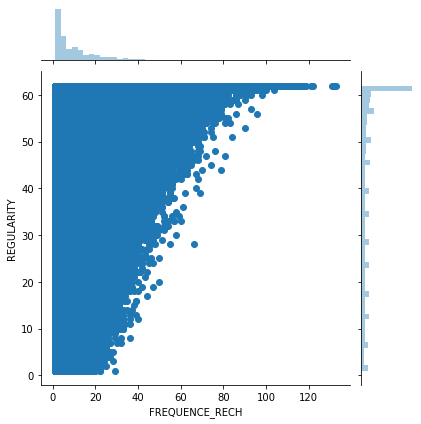

In [105]:
sns.jointplot(x=df_pd.FREQUENCE_RECH, y=df_pd.REGULARITY, data=df_pd)

Text(0.5, 1.0, 'Distribution of churn by top-up amount')

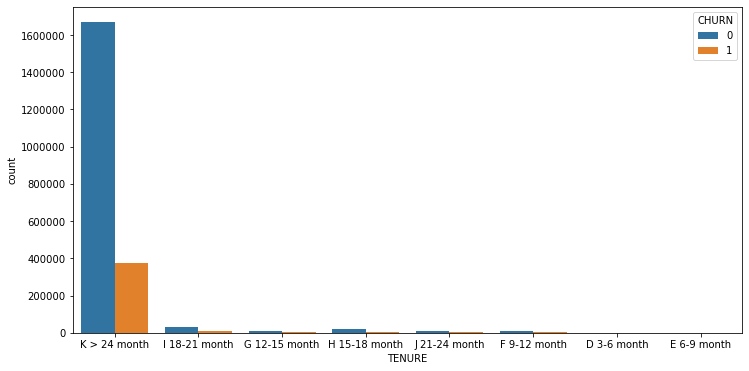

<Figure size 864x576 with 0 Axes>

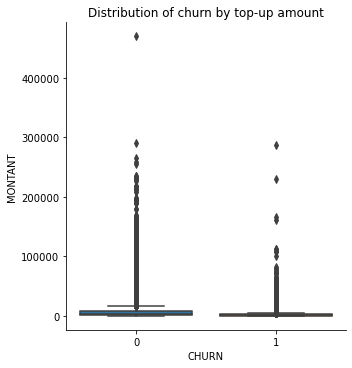

In [107]:
plt.figure(figsize=(12,6))
sns.countplot(x= df_pd.TENURE, hue= df_pd.CHURN, data=df_pd)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.figure(figsize=(12,8))
sns.catplot(x="CHURN", y="MONTANT", kind= 'box', data=df_pd)
plt.title('Distribution of churn by top-up amount')


In [125]:
df_pd.groupby('CHURN')['TENURE'].value_counts(normalize=True).sort_values(ascending=False)

CHURN  TENURE       
0      K > 24 month     0.953573
1      K > 24 month     0.926738
       I 18-21 month    0.030563
0      I 18-21 month    0.018817
1      H 15-18 month    0.017139
       G 12-15 month    0.011666
0      H 15-18 month    0.010904
1      J 21-24 month    0.007273
0      G 12-15 month    0.005822
       J 21-24 month    0.005592
1      F 9-12 month     0.005545
0      F 9-12 month     0.004050
       E 6-9 month      0.000870
1      E 6-9 month      0.000782
0      D 3-6 month      0.000372
1      D 3-6 month      0.000295
Name: TENURE, dtype: float64

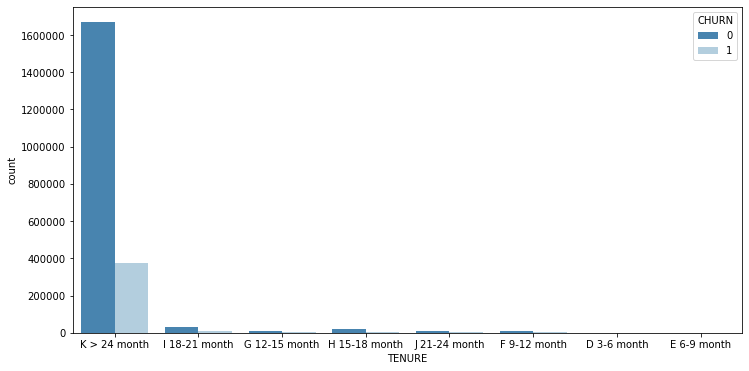

In [128]:
plt.figure(figsize = [12,6])
sns.countplot(data=df_pd, x='TENURE', hue='CHURN', palette='Blues_r')
plt.ticklabel_format(style='plain', axis='y',useOffset=False);

Majority of those who churned have been customers for more than two years

In [129]:
df_pd.query('CHURN == 1')['REGION'].value_counts(normalize=True)[:10].sort_values(ascending=False)

DAKAR          0.419931
THIES          0.124835
KAOLACK        0.096678
DIOURBEL       0.079963
LOUGA          0.067203
SAINT-LOUIS    0.064651
TAMBACOUNDA    0.035983
ZIGUINCHOR     0.025605
MATAM          0.024839
FATICK         0.021522
Name: REGION, dtype: float64

Majority of those who churned are from the Dakar region.

<Figure size 864x576 with 0 Axes>

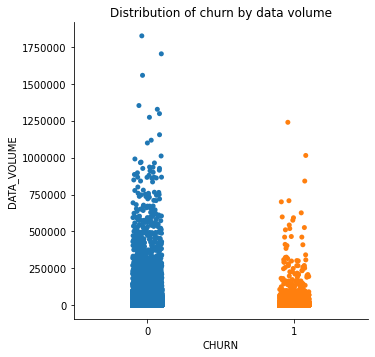

In [141]:
plt.figure(figsize=(12,8))
sns.catplot(x="CHURN", y="DATA_VOLUME", kind= 'strip', data=df_pd)
plt.title('Distribution of churn by data volume')
plt.ticklabel_format(style='plain', axis='y',useOffset=False);

<Figure size 864x576 with 0 Axes>

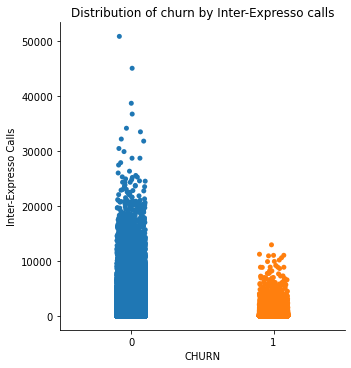

<Figure size 864x576 with 0 Axes>

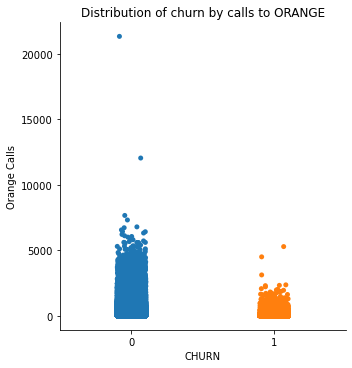

<Figure size 864x576 with 0 Axes>

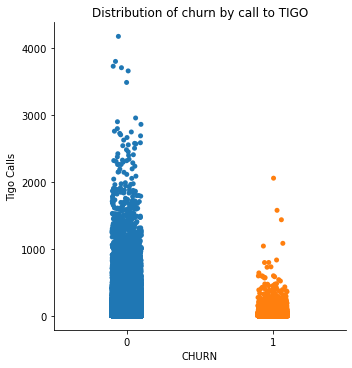

In [12]:
plt.figure(figsize=(12,8))
sns.catplot(x="CHURN", y="ON_NET", kind= 'strip', data=df_pd)
plt.title('Distribution of churn by Inter-Expresso calls')
plt.ylabel("Inter-Expresso Calls")
plt.ticklabel_format(style='plain', axis='y',useOffset=False);
 
plt.figure(figsize=(12,8))
sns.catplot(x="CHURN", y="ORANGE", kind= 'strip', data=df_pd)
plt.title('Distribution of churn by calls to ORANGE')
plt.ylabel("Orange Calls")
plt.ticklabel_format(style='plain', axis='y',useOffset=False);

plt.figure(figsize=(12,8))
sns.catplot(x="CHURN", y="TIGO", kind= 'strip', data=df_pd)
plt.title('Distribution of churn by call to TIGO')
plt.ylabel("Tigo Calls")
plt.ticklabel_format(style='plain', axis='y',useOffset=False);

Customers who churned earned less, spent less to top up and data volume. They also called less on either on Epresso, Tigo or Orange.

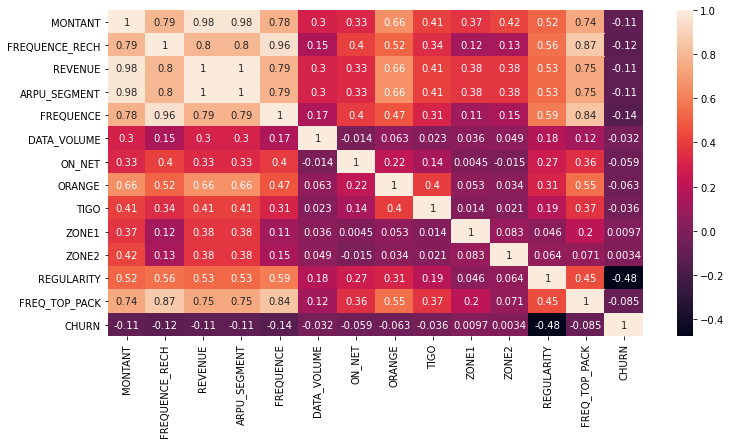

In [137]:
plt.figure(figsize=(12,6))
sns.heatmap(df_pd.corr(), annot= True)